In [42]:
# Libraries
import pandas as pd
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel

In [2]:
# What are the differences in RB and EB in VK/LO sunny/cloudy conditions, and how can we explan them?

In [3]:
###### DATA PREP ######

In [4]:
# Data download
cloudy_VK_LB = pd.read_csv(r"C:\Users\48512\Desktop\Climate Studies\Period 5 and 6\Field Training Soil-Vegetation-Atmosphere Interactions\VK_LO\VK_LB_Cloudy_30min(in).csv")
sunny_VK_LB = pd.read_csv(r"C:\Users\48512\Desktop\Climate Studies\Period 5 and 6\Field Training Soil-Vegetation-Atmosphere Interactions\VK_LO\VK_LB_Sunny_30min(in).csv")
    

In [5]:
# Deleting the rows from cloudy_VK_LB that are wrong (morning fog)
cloudy_VK_LB = cloudy_VK_LB.drop([15]) # 7:30
cloudy_VK_LB = cloudy_VK_LB.drop([16]) # 8:00

In [6]:
# Add a Q* column
# Q* = H + LE + G

cloudy_VK_LB['Q*_VK'] = cloudy_VK_LB['H_VK'] + cloudy_VK_LB['LE_VK'] + cloudy_VK_LB['G_VK']
cloudy_VK_LB['Q*_LB'] = cloudy_VK_LB['H_LB'] + cloudy_VK_LB['LE_LB'] + cloudy_VK_LB['G_LB']

sunny_VK_LB['Q*_VK'] = sunny_VK_LB['H_VK'] + sunny_VK_LB['LE_VK'] + sunny_VK_LB['G_VK']
sunny_VK_LB['Q*_LB'] = sunny_VK_LB['H_LB'] + sunny_VK_LB['LE_LB'] + sunny_VK_LB['G_LB']

In [7]:
# Adding the Bowen ratio B collumn

cloudy_VK_LB['B_VK'] = cloudy_VK_LB['H_VK'] / cloudy_VK_LB['LE_VK']
cloudy_VK_LB['B_LB'] = cloudy_VK_LB['H_LB'] / cloudy_VK_LB['LE_LB']

sunny_VK_LB['B_VK'] = sunny_VK_LB['H_VK'] / sunny_VK_LB['LE_VK']
sunny_VK_LB['B_LB'] = sunny_VK_LB['H_LB'] / sunny_VK_LB['LE_LB']

In [15]:
# Cleaning NaNs

cloudy_VK_LB.dropna(inplace=True)
sunny_VK_LB.dropna(inplace=True)

In [17]:
pd.set_option??

Signature:   pd.set_option(*args, **kwds) -> 'T'
Type:        CallableDynamicDoc
String form: <pandas._config.config.CallableDynamicDoc object at 0x0000026828E72870>
File:        c:\users\48512\anaconda3\lib\site-packages\pandas\_config\config.py
Source:     
class CallableDynamicDoc(Generic[T]):
    def __init__(self, func: Callable[..., T], doc_tmpl: str) -> None:
        self.__doc_tmpl__ = doc_tmpl
        self.__func__ = func

    def __call__(self, *args, **kwds) -> T:
        return self.__func__(*args, **kwds)

    # error: Signature of "__doc__" incompatible with supertype "object"
    @property
    def __doc__(self) -> str:  # type: ignore[override]
        opts_desc = _describe_option("all", _print_desc=False)
        opts_list = pp_options_list(list(_registered_options.keys()))
        return self.__doc_tmpl__.format(opts_desc=opts_desc, opts_list=opts_list)

In [19]:
pd.set_option('display.max_columns', None)  # Show all columns


In [21]:
# Sanity check if the Rn from the dataset is correct
# VK sunny looks just like rounding errors
# VK cloudy looks just like rounding errors
# LB cloudy looks just like rounding errors
# LB sunny looks just like rounding errors

df = cloudy_VK_LB # sunny_VK_LB or sunny_VK_LB
loc = 'LB' # VK or LB

Rn_check = df[f'SW_IN_{loc}'] - df[f'SW_OUT_{loc}'] + df[f'LW_IN_{loc}'] - df[f'LW_OUT_{loc}']
check = df[f'RN_{loc}'] - Rn_check
check

0    -4.973799e-14
1     4.973799e-14
2    -3.552714e-15
3    -7.105427e-15
4     3.907985e-14
5    -3.552714e-15
6     3.197442e-14
7     5.506706e-14
9     8.881784e-15
12    0.000000e+00
13    2.131628e-14
14   -7.105427e-14
17    0.000000e+00
18    8.526513e-14
19    2.842171e-14
20    5.684342e-14
21    0.000000e+00
22    0.000000e+00
23    0.000000e+00
24    0.000000e+00
25    2.842171e-14
26    0.000000e+00
27    5.684342e-14
28    1.136868e-13
29    1.136868e-13
30   -1.421085e-14
31   -2.842171e-14
32    1.421085e-14
33   -4.618528e-14
34    2.131628e-14
35   -1.421085e-14
36    4.263256e-14
37    1.598721e-14
38    0.000000e+00
39   -3.552714e-14
40    1.598721e-14
41    0.000000e+00
42   -7.105427e-15
43    1.776357e-14
44   -1.421085e-14
45    5.329071e-15
46    4.263256e-14
47    1.421085e-14
48   -4.973799e-14
dtype: float64

In [23]:
# Adding a datetime index

cloudy_VK_LB['datetime'] = pd.to_datetime(cloudy_VK_LB['Timestamp'])
cloudy_VK_LB.set_index('datetime', inplace=True)  # set datetime as index


sunny_VK_LB['datetime'] = pd.to_datetime(sunny_VK_LB['Timestamp'])
sunny_VK_LB.set_index('datetime', inplace=True)  # set datetime as index

In [25]:
###### END DATA PREP ######

In [27]:
###### RADIATION AND ENERGY BALANCE ######

In [29]:
# Most of the basic analysis was already done, e.g., timeseries

In [48]:
def compare_location_data(df, alpha=0.05):
    """
    Compare mean, std, correlation, t-test, and p-value for each variable between two location columns.
    Assumes paired samples (same indices) for meaningful correlation and paired t-test.
    Variable columns should end in _VK and _LB for each location.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing paired columns ending in _VK and _LB
        alpha (float): Significance threshold for p-value (default 0.05)
    
    Returns:
        pd.DataFrame: Summary table with statistics.
    """
    results = []
    
    # Extract base variable names (before _VK or _LB)
    vk_vars = [col for col in df.columns if col.endswith('_VK')]
    base_vars = [col[:-3] for col in vk_vars]  # remove '_VK'

    for base in base_vars:
        var_vk = f'{base}_VK'
        var_lb = f'{base}_LB'

        if var_vk in df.columns and var_lb in df.columns:
            paired = df[[var_vk, var_lb]].dropna()
            x = paired[var_vk]
            y = paired[var_lb]

            if len(x) == 0:
                continue

            # Paired t-test
            t_stat, p_val = ttest_ind(x, y)

            # Correlation of paired samples
            corr = x.corr(y)

            results.append({
                'Variable': base,
                'VK Mean': x.mean(),
                'LB Mean': y.mean(),
                'VK Std': x.std(),
                'LB Std': y.std(),
                'Correlation': corr,
                'T-stat': t_stat,
                'P-value': p_val,
                'Significantly Different': 'Yes' if p_val < alpha else 'No',
            })

    return pd.DataFrame(results)


In [33]:
# def compare_location_data(df1, df2, alpha=0.05):
#     """
#     Compare mean, std, correlation, t-test, and p-value for each variable between two location dataframes.
#     Assumes paired samples (same indices) for meaningful correlation and paired t-test.
    
#     Parameters:
#         df1 (pd.DataFrame): DataFrame for first location (variables as columns)
#         df2 (pd.DataFrame): DataFrame for second location (variables as columns)
#         alpha (float): Significance threshold for p-value (default 0.05)
    
#     Returns:
#         pd.DataFrame: Summary table with statistics.
#     """
#     results = []

#     # Find common variables between two dataframes
#     common_vars = df1.columns.intersection(df2.columns)

#     for var in common_vars:
#         # Align the two series on the index and drop missing values in either
#         paired = pd.concat([df1[var], df2[var]], axis=1).dropna()
#         x = paired.iloc[:, 0]
#         y = paired.iloc[:, 1]

#         if len(x) == 0:
#             continue

#         # Paired t-test
#         t_stat, p_val = ttest_rel(x, y)

#         # Correlation of paired samples
#         corr = x.corr(y)

#         results.append({
#             'Variable': var,
#             'Location1 Mean': x.mean(),
#             'Location2 Mean': y.mean(),
#             'Location1 Std': x.std(),
#             'Location2 Std': y.std(),
#             'Correlation': corr,
#             'T-stat': t_stat,
#             'P-value': p_val,
#             'Significantly Different': 'Yes' if p_val < alpha else 'No',
#         })

#     return pd.DataFrame(results)

In [35]:
# def compare_location_data(df1, df2, variables=None, alpha=0.05):
#     """
#     Compare mean, std, correlation, t-test, and p-value for each variable between two location dataframes.
    
#     Parameters:
#         df1 (pd.DataFrame): DataFrame for first location (variables as columns)
#         df2 (pd.DataFrame): DataFrame for second location (variables as columns)
#         variables (list or None): List of variables to compare. If None, compare all common variables.
#         alpha (float): Significance threshold for p-value (default 0.05)
    
#     Returns:
#         pd.DataFrame: Summary table with statistics.
#     """
#     results = []

#     # Determine variables to compare
#     if variables is None:
#         variables_to_compare = df1.columns.intersection(df2.columns)
#     else:
#         # Only keep variables that exist in both dfs
#         variables_to_compare = [var for var in variables if var in df1.columns and var in df2.columns]

#     for var in variables_to_compare:
#         x = df1[var].dropna()
#         y = df2[var].dropna()

#         if len(x) == 0 or len(y) == 0:
#             continue

#         # T-test
#         t_stat, p_val = ttest_ind(x, y, equal_var=False)

#         # Calculate correlation only if lengths match (for paired samples)
#         corr = np.nan
#         min_len = min(len(x), len(y))
#         if min_len > 1:
#             corr = np.corrcoef(x[:min_len], y[:min_len])[0, 1]

#         results.append({
#             'Variable': var,
#             'Location1 Mean': x.mean(),
#             'Location2 Mean': y.mean(),
#             'Location1 Std': x.std(),
#             'Location2 Std': y.std(),
#             'Correlation': corr,
#             'T-stat': t_stat,
#             'P-value': p_val,
#             'Significantly Different': 'Yes' if p_val < alpha else 'No',
#         })

#     return pd.DataFrame(results)


In [148]:
sunny_VK_LB

,Timestamp,SW_IN_VK,SW_OUT_VK,LW_IN_VK,LW_OUT_VK,RN_VK,H_VK,LE_VK,G_VK,SW_IN_LB,SW_OUT_LB,LW_IN_LB,LW_OUT_LB,RN_LB,H_LB,LE_LB,G_LB,Q*_VK,Q*_LB,B_VK,B_LB,hour
datetime,,,,,,,,,,,,,,,,,,,,,,
2025-06-13 00:00:00,6/13/2025 0:00,-1.637,-1.597,361.0,401.6,-40.6,-60.51400,44.50990,-12.778656,-5.140,-2.694,361.6,414.8,-55.646,-34.775900,4.333660,6.302235,-28.782756,-24.140005,-1.359563,-8.024603,0
2025-06-13 00:30:00,6/13/2025 0:30,-1.637,-1.746,358.0,394.2,-36.1,-35.54180,22.90690,-12.751514,-4.816,-2.701,363.5,413.6,-52.215,-25.247700,3.013190,6.064068,-25.386414,-16.170442,-1.551576,-8.379060,0
2025-06-13 01:00:00,6/13/2025 1:00,-1.616,-1.640,358.4,393.9,-35.5,-23.21520,12.33460,-12.079626,-4.918,-2.655,358.9,411.5,-54.863,-23.680500,2.484860,5.331260,-22.960226,-15.864380,-1.882120,-9.529913,1
2025-06-13 01:30:00,6/13/2025 1:30,-1.357,-1.331,358.7,393.7,-35.0,-18.08540,8.38928,-11.840035,-4.864,-2.783,359.0,409.1,-52.181,-31.392500,2.079850,4.807074,-21.536155,-24.505576,-2.155775,-15.093637,1
2025-06-13 02:00:00,6/13/2025 2:00,-1.282,-1.544,368.8,391.5,-22.4,-23.54290,13.59710,-12.835081,-4.368,-2.828,366.8,406.2,-40.940,-16.751100,0.352737,4.478113,-22.780881,-11.920250,-1.731465,-47.488922,2
2025-06-13 02:30:00,6/13/2025 2:30,-1.336,-1.395,361.6,395.5,-33.8,-18.27870,12.56470,-12.483554,-4.488,-2.766,362.1,403.9,-43.522,-9.950810,-0.864835,4.201505,-18.197554,-6.614140,-1.454766,11.506021,2
2025-06-13 03:00:00,6/13/2025 3:00,-0.668,-1.523,352.9,385.7,-31.9,-11.99210,7.43859,-9.409238,-3.324,-2.596,354.8,402.3,-48.228,-9.807570,-0.521589,4.007137,-13.962748,-6.322022,-1.612147,18.803253,3
2025-06-13 03:30:00,6/13/2025 3:30,7.283,0.032,357.4,384.6,-19.9,-9.81378,8.65645,-6.845209,5.267,-1.564,354.1,401.7,-40.769,-16.303800,-0.618181,3.937703,-8.002539,-12.984278,-1.133696,26.373829,3
2025-06-13 04:00:00,6/13/2025 4:00,29.779,7.796,363.7,394.3,-8.6,-17.69070,13.44600,-5.459668,38.650,3.125,375.8,402.6,8.725,-20.393700,2.211750,3.938234,-9.704368,-14.243716,-1.315685,-9.220617,4


In [50]:
print(compare_location_data(sunny_VK_LB))
compare_location_sunny = compare_location_data(sunny_VK_LB)
compare_location_sunny.to_excel("sunny_VK_LB.xlsx", index=False)

  Variable     VK Mean     LB Mean      VK Std      LB Std  Correlation  \
0    SW_IN  320.739163  317.681429  344.802594  336.958997     0.997023   
1   SW_OUT   61.268551   30.150000   64.468047   33.347655     0.993025   
2    LW_IN  385.579592  385.210204   21.097462   18.156636     0.967315   
3   LW_OUT  448.016327  450.710204   44.625868   31.558208     0.928778   
4       RN  197.036735  222.031429  254.134969  292.991804     0.995757   
5        H    3.420930   70.314108   39.070551  116.504053     0.849566   
6       LE  145.643975   57.913883  143.775781   63.582242     0.859747   
7        G   21.654612   14.387276   43.109049    8.839665     0.387478   
8       Q*  170.719518  142.615267  215.210866  182.901906     0.953286   
9        B   -0.568541   -2.811000    0.760925   17.173636     0.296469   

     T-stat   P-value Significantly Different  
0  0.044397  0.964680                      No  
1  3.001142  0.003428                     Yes  
2  0.092896  0.926180         

In [52]:
print(compare_location_data(cloudy_VK_LB))
compare_location_cloudy = compare_location_data(cloudy_VK_LB)
compare_location_cloudy.to_excel("cloudy_VK_LB.xlsx", index=False)

  Variable     VK Mean     LB Mean      VK Std      LB Std  Correlation  \
0    SW_IN  165.727818  139.025182  233.525479  221.621136     0.673620   
1   SW_OUT   35.690000   12.223295   50.609083   22.193601     0.690445   
2    LW_IN  395.640909  395.334091   24.911203   15.657214     0.480467   
3   LW_OUT  417.840909  418.034091   16.360038    8.051836     0.795442   
4       RN  107.837818  104.101886  178.336718  195.023578     0.689710   
5        H    4.368057   10.631425   41.166037   67.652264     0.489261   
6       LE   91.084993   54.658386   95.879814   79.519326     0.807176   
7        G    0.582134    6.799931   19.401361    3.278022     0.421441   
8       Q*   96.035184   72.089742  144.675868  124.958996     0.775805   
9        B    6.536510    3.672233   45.152710   16.227405    -0.014238   

     T-stat   P-value Significantly Different  
0  0.550168  0.583630                      No  
1  2.816798  0.006015                     Yes  
2  0.069170  0.945015         

In [ ]:
###### END RADIATION AND ENERGY BALANCE ######

In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # Example assuming your dataframe is named sunny_VK_LB and datetime is the index

# # Select the columns you want for the radar plot
# data = sunny_VK_LB[['RN_VK', 'LE_VK', 'H_VK']]

# # Take the mean (or any aggregate) over the time to get one value per variable for the plot
# mean_values = data.mean()

# # Number of variables
# categories = list(mean_values.index)
# N = len(categories)

# # What will be the angle of each axis in the plot? (divide the plot / number of variables)
# angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
# angles += angles[:1]  # Complete the loop

# # Values to plot, and close the loop
# values = mean_values.tolist()
# values += values[:1]

# # Create figure and polar subplot
# fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# # Draw one axe per variable + add labels
# ax.set_theta_offset(np.pi / 2)
# ax.set_theta_direction(-1)
# plt.xticks(angles[:-1], categories)

# # Draw ylabels
# ax.set_rlabel_position(0)
# plt.yticks(color="grey", size=7)
# plt.ylim(0, 200)

# # Plot data
# ax.plot(angles, values, linewidth=2, linestyle='solid', label='Mean values')
# ax.fill(angles, values, alpha=0.25)

# # Add a title and legend
# plt.title('Spider Plot of RN_VK, LE_VK, and H_VK (Mean Values)')
# plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# plt.show()


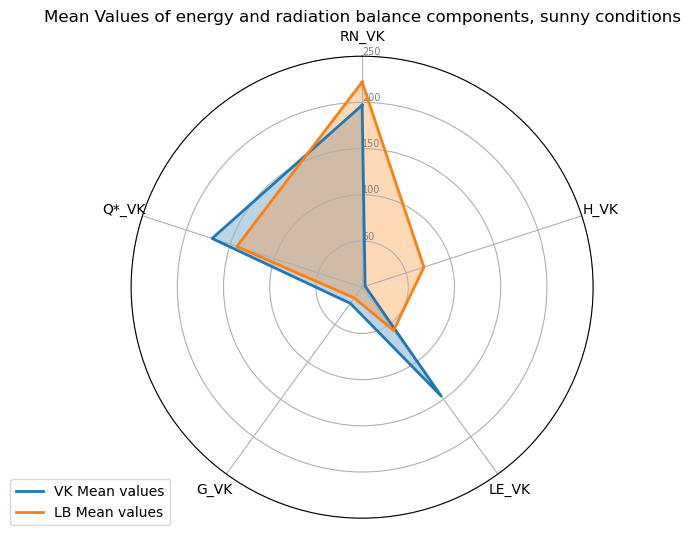

In [54]:
# Select variables for the two plots
vars_vk = ['RN_VK', 'H_VK', 'LE_VK', 'G_VK', 'Q*_VK']
vars_lb = ['RN_LB', 'H_LB', 'LE_LB', 'G_LB', 'Q*_LB']

# Calculate mean values for both sets
mean_vk = sunny_VK_LB[vars_vk].mean()
mean_lb = sunny_VK_LB[vars_lb].mean()

# Categories and number of variables
categories = vars_vk  # same variables on both plots, just RN_VK vs RN_LB differ in name
N = len(categories)

# Compute angles for each axis in the plot
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Prepare values for plotting, closing the loop
values_vk = mean_vk.tolist()
values_vk += values_vk[:1]

values_lb = mean_lb.tolist()
values_lb += values_lb[:1]

# Create figure and polar subplot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Setup the plot style
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], categories)

ax.set_rlabel_position(0)
plt.yticks(color="grey", size=7)
plt.ylim(0, 250)

# Plot first dataset
ax.plot(angles, values_vk, linewidth=2, linestyle='solid', label='VK Mean values')
ax.fill(angles, values_vk, alpha=0.3)  # more opaque

# Plot second dataset
ax.plot(angles, values_lb, linewidth=2, linestyle='solid', label='LB Mean values')
ax.fill(angles, values_lb, alpha=0.3)  # more opaque

# Title and legend
plt.title('Mean Values of energy and radiation balance components, sunny conditions')
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()


In [ ]:
# Select variables for the two plots
vars_vk = ['RN_VK', 'H_VK', 'LE_VK', 'G_VK', 'Q*_VK']
vars_lb = ['RN_LB', 'H_LB', 'LE_LB', 'G_LB', 'Q*_LB']

# Calculate mean values for both sets
mean_vk = cloudy_VK_LB[vars_vk].mean()
mean_lb = cloudy_VK_LB[vars_lb].mean()

# Categories and number of variables
categories = vars_vk  # same variables on both plots, just RN_VK vs RN_LB differ in name
N = len(categories)

# Compute angles for each axis in the plot
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Prepare values for plotting, closing the loop
values_vk = mean_vk.tolist()
values_vk += values_vk[:1]

values_lb = mean_lb.tolist()
values_lb += values_lb[:1]

# Create figure and polar subplot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Setup the plot style
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], categories)

ax.set_rlabel_position(0)
plt.yticks(color="grey", size=7)
plt.ylim(0, 120)

# Plot first dataset
ax.plot(angles, values_vk, linewidth=2, linestyle='solid', label='VK Mean values')
ax.fill(angles, values_vk, alpha=0.3)  # more opaque

# Plot second dataset
ax.plot(angles, values_lb, linewidth=2, linestyle='solid', label='LB Mean values')
ax.fill(angles, values_lb, alpha=0.3)  # more opaque

# Title and legend
plt.title('Mean Values of energy and radiation balance components, cloudy conditions')
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()

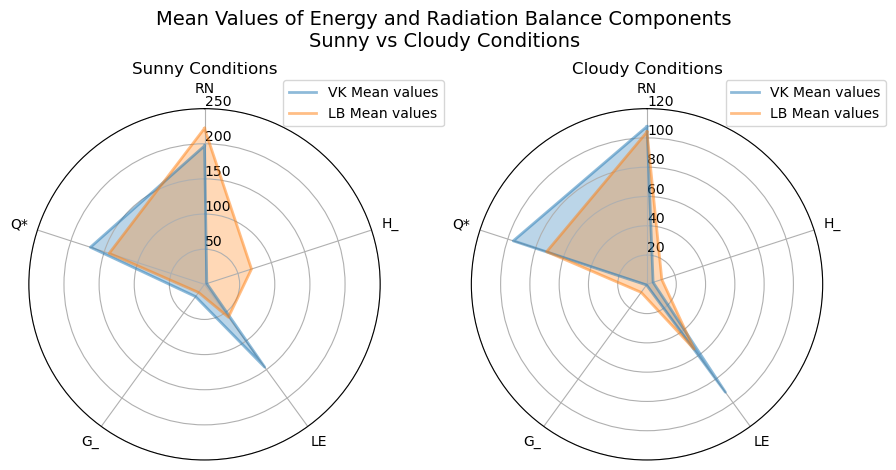

In [78]:
# Define variables
vars_vk = ['RN_VK', 'H_VK', 'LE_VK', 'G_VK', 'Q*_VK']
vars_lb = ['RN_LB', 'H_LB', 'LE_LB', 'G_LB', 'Q*_LB']
categories = vars_vk
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # Close the loop

# Prepare figure with two polar subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(9, 5), subplot_kw=dict(polar=True))

### SUNNY CONDITIONS ###
mean_vk_sunny = sunny_VK_LB[vars_vk].mean().tolist()
mean_lb_sunny = sunny_VK_LB[vars_lb].mean().tolist()
values_vk_sunny = mean_vk_sunny + mean_vk_sunny[:1]
values_lb_sunny = mean_lb_sunny + mean_lb_sunny[:1]

ax = axes[0]
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(0)
ax.set_ylim(0, 250)
short_labels = [var[:2] for var in categories]
ax.set_xticks(angles[:-1])
ax.set_xticklabels(short_labels)
ax.plot(angles, values_vk_sunny, linewidth=2, linestyle='solid', label='VK Mean values', alpha=0.5)
ax.fill(angles, values_vk_sunny, alpha=0.3)
ax.plot(angles, values_lb_sunny, linewidth=2, linestyle='solid', label='LB Mean values', alpha=0.5)
ax.fill(angles, values_lb_sunny, alpha=0.3)
ax.set_title('Sunny Conditions')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

### CLOUDY CONDITIONS ###
mean_vk_cloudy = cloudy_VK_LB[vars_vk].mean().tolist()
mean_lb_cloudy = cloudy_VK_LB[vars_lb].mean().tolist()
values_vk_cloudy = mean_vk_cloudy + mean_vk_cloudy[:1]
values_lb_cloudy = mean_lb_cloudy + mean_lb_cloudy[:1]

ax = axes[1]
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(0)
ax.set_ylim(0, 120)
short_labels = [var[:2] for var in categories]
ax.set_xticks(angles[:-1])
ax.set_xticklabels(short_labels)
ax.plot(angles, values_vk_cloudy, linewidth=2, linestyle='solid', label='VK Mean values', alpha=0.5)
ax.fill(angles, values_vk_cloudy, alpha=0.3)
ax.plot(angles, values_lb_cloudy, linewidth=2, linestyle='solid', label='LB Mean values', alpha=0.5)
ax.fill(angles, values_lb_cloudy, alpha=0.3)
ax.set_title('Cloudy Conditions')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

# Super title for the whole figure
plt.suptitle('Mean Values of Energy and Radiation Balance Components\nSunny vs Cloudy Conditions', fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
plt.xticks??

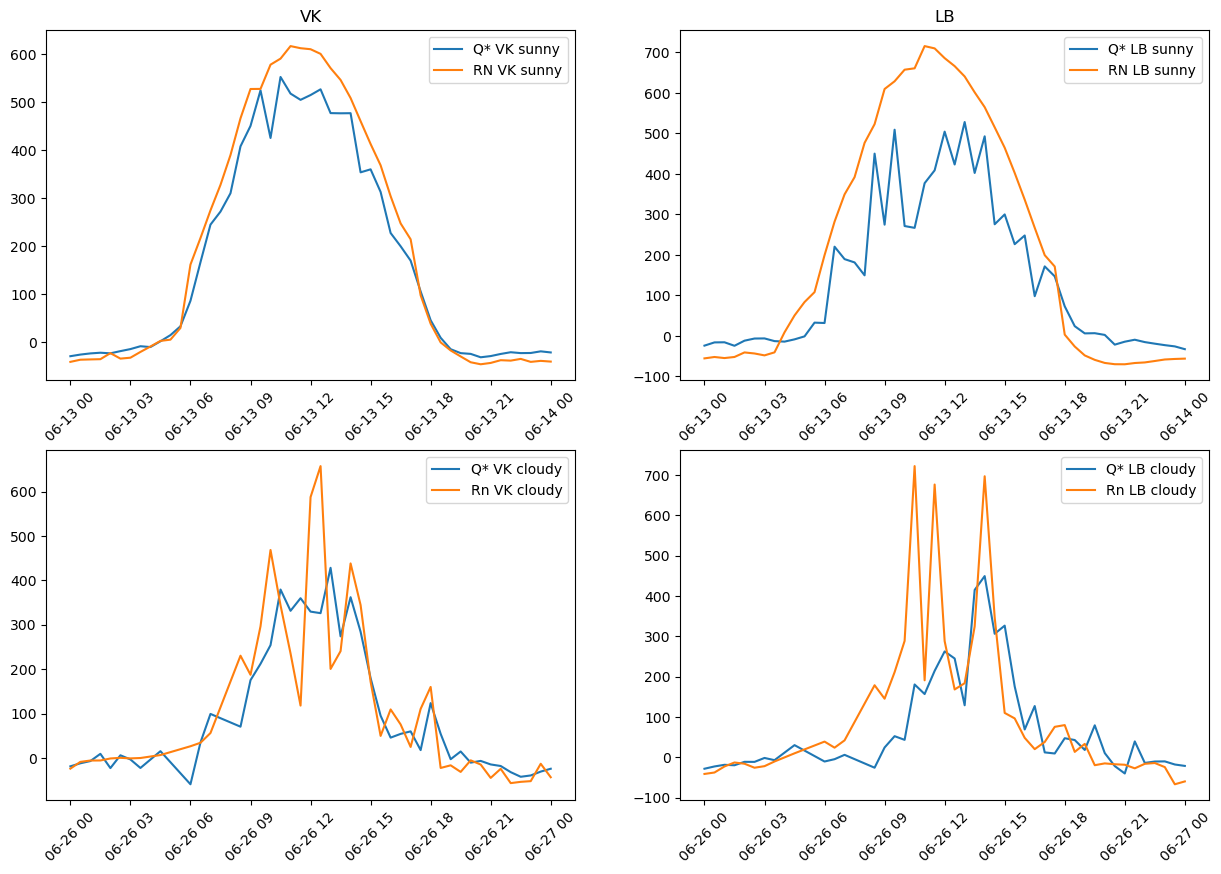

In [80]:
# Plots of Rn and Q*
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0,0].plot(sunny_VK_LB.index, sunny_VK_LB['Q*_VK'], label="Q* VK sunny")
axs[0,0].plot(sunny_VK_LB.index, sunny_VK_LB['RN_VK'], label="RN VK sunny")
axs[0,0].set_title('VK')
axs[0,0].legend()
axs[0,0].tick_params(axis='x', rotation=45)

axs[0,1].plot(sunny_VK_LB.index, sunny_VK_LB['Q*_LB'], label="Q* LB sunny")
axs[0,1].plot(sunny_VK_LB.index, sunny_VK_LB['RN_LB'], label="RN LB sunny")
axs[0,1].set_title('LB')
axs[0,1].legend()
axs[0,1].tick_params(axis='x', rotation=45)

axs[1,0].plot(cloudy_VK_LB.index, cloudy_VK_LB['Q*_VK'], label="Q* VK cloudy")
axs[1,0].plot(cloudy_VK_LB.index, cloudy_VK_LB['RN_VK'], label="Rn VK cloudy")
#axs[1,0].set_title('Cloudy')
axs[1,0].legend()
axs[1,0].tick_params(axis='x', rotation=45)

axs[1,1].plot(cloudy_VK_LB.index, cloudy_VK_LB['Q*_LB'], label="Q* LB cloudy")
axs[1,1].plot(cloudy_VK_LB.index, cloudy_VK_LB['RN_LB'], label="Rn LB cloudy")
#axs[1,1].set_title('Rn - Q*, cloudy conditions LB')
axs[1,1].tick_params(axis='x', rotation=45)  # <-- This rotates x-axis labels
axs[1,1].legend()

# # Rotate x-axis ticks for both plots
# for ax in axs:
#     plt.setp(ax.get_xticklabels(), rotation=45)

# axs[0].set_ylabel('Rn - Q* [W/m2]')
# axs[0].set_xlabel('time')
# axs[1].set_xlabel('time')

# plt.tight_layout()  # to avoid overlap
# plt.show()


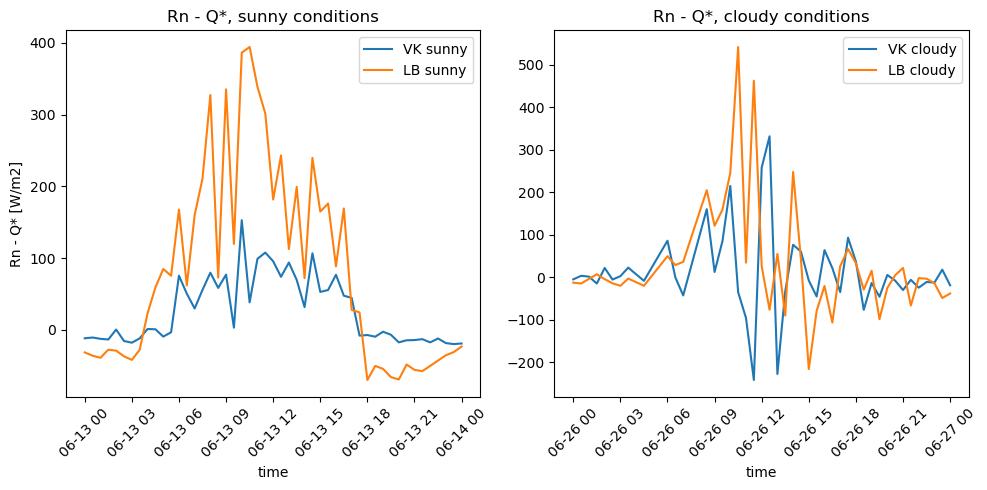

In [81]:
# Is the Rn = Q*?
fig, axs = plt.subplots(1, 2, figsize=(10,5))

energy_diff_sun_VK = sunny_VK_LB['RN_VK'] - sunny_VK_LB['Q*_VK']
axs[0].plot(sunny_VK_LB.index, energy_diff_sun_VK, label="VK sunny")
energy_diff_sun_LB = sunny_VK_LB['RN_LB'] - sunny_VK_LB['Q*_LB']
axs[0].plot(sunny_VK_LB.index, energy_diff_sun_LB, label="LB sunny")
axs[0].set_title('Rn - Q*, sunny conditions')
axs[0].legend()


energy_diff_cloudy_VK = cloudy_VK_LB['RN_VK'] - cloudy_VK_LB['Q*_VK']
axs[1].plot(cloudy_VK_LB.index, energy_diff_cloudy_VK, label="VK cloudy")
energy_diff_cloudy_LB = cloudy_VK_LB['RN_LB'] - cloudy_VK_LB['Q*_LB']
axs[1].plot(cloudy_VK_LB.index, energy_diff_cloudy_LB, label="LB cloudy")
axs[1].set_title('Rn - Q*, cloudy conditions')
axs[1].legend()

# Rotate x-axis ticks for both plots
for ax in axs:
    plt.setp(ax.get_xticklabels(), rotation=45)

axs[0].set_ylabel('Rn - Q* [W/m2]')
axs[0].set_xlabel('time')
axs[1].set_xlabel('time')

plt.tight_layout()  # to avoid overlap
plt.show()

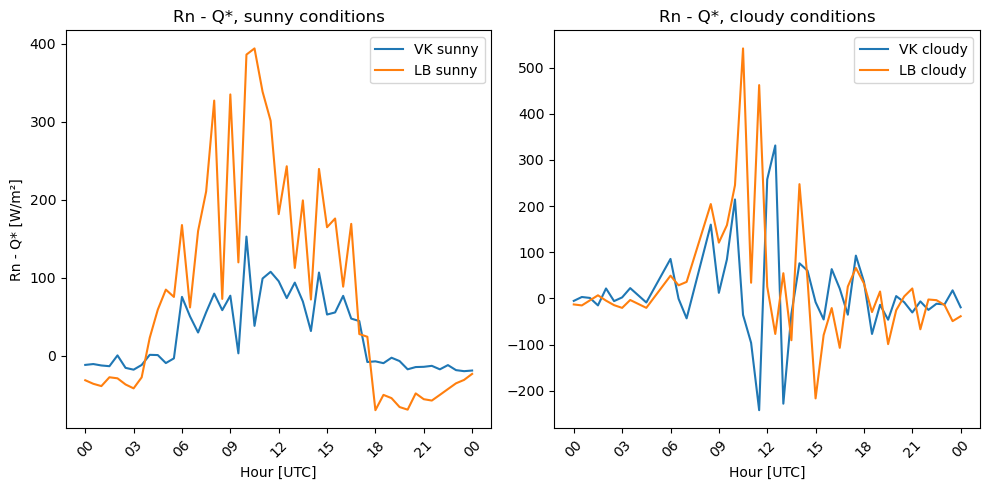

In [144]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Sunny conditions
energy_diff_sun_VK = sunny_VK_LB['RN_VK'] - sunny_VK_LB['Q*_VK']
axs[0].plot(sunny_VK_LB.index, energy_diff_sun_VK, label="VK sunny")
energy_diff_sun_LB = sunny_VK_LB['RN_LB'] - sunny_VK_LB['Q*_LB']
axs[0].plot(sunny_VK_LB.index, energy_diff_sun_LB, label="LB sunny")
axs[0].set_title('Rn - Q*, sunny conditions')
axs[0].legend()

# Cloudy conditions
energy_diff_cloudy_VK = cloudy_VK_LB['RN_VK'] - cloudy_VK_LB['Q*_VK']
axs[1].plot(cloudy_VK_LB.index, energy_diff_cloudy_VK, label="VK cloudy")
energy_diff_cloudy_LB = cloudy_VK_LB['RN_LB'] - cloudy_VK_LB['Q*_LB']
axs[1].plot(cloudy_VK_LB.index, energy_diff_cloudy_LB, label="LB cloudy")
axs[1].set_title('Rn - Q*, cloudy conditions')
axs[1].legend()

# Format x-axis to show only the hour
hour_formatter = mdates.DateFormatter('%H')
for ax in axs:
    ax.xaxis.set_major_formatter(hour_formatter)
    plt.setp(ax.get_xticklabels(), rotation=45)

axs[0].set_ylabel('Rn - Q* [W/m²]')
axs[0].set_xlabel('Hour [UTC]')
axs[1].set_xlabel('Hour [UTC]')

plt.tight_layout()
plt.show()


In [82]:
energy_diff_sun_VK = energy_diff_sun_VK.mean()
energy_diff_sun_LB = energy_diff_sun_LB.mean()
energy_diff_cloudy_VK = energy_diff_cloudy_VK.mean()
energy_diff_cloudy_LB = energy_diff_cloudy_LB.mean()

print(f'mean energy_diff_sun_VK {energy_diff_sun_VK }')
print(f'mean energy_diff_sun_LB {energy_diff_sun_LB }')
print(f'mean energy_diff_cloudy_VK {energy_diff_cloudy_VK }')
print(f'mean energy_diff_cloudy_LB {energy_diff_cloudy_LB }')

mean energy_diff_sun_VK 26.31721710287755
mean energy_diff_sun_LB 79.41616168287756
mean energy_diff_cloudy_VK 11.80263436481818
mean energy_diff_cloudy_LB 32.01214440463637


In [146]:
sunny_VK_LB

,Timestamp,SW_IN_VK,SW_OUT_VK,LW_IN_VK,LW_OUT_VK,RN_VK,H_VK,LE_VK,G_VK,SW_IN_LB,SW_OUT_LB,LW_IN_LB,LW_OUT_LB,RN_LB,H_LB,LE_LB,G_LB,Q*_VK,Q*_LB,B_VK,B_LB,hour
datetime,,,,,,,,,,,,,,,,,,,,,,
2025-06-13 00:00:00,6/13/2025 0:00,-1.637,-1.597,361.0,401.6,-40.6,-60.51400,44.50990,-12.778656,-5.140,-2.694,361.6,414.8,-55.646,-34.775900,4.333660,6.302235,-28.782756,-24.140005,-1.359563,-8.024603,0
2025-06-13 00:30:00,6/13/2025 0:30,-1.637,-1.746,358.0,394.2,-36.1,-35.54180,22.90690,-12.751514,-4.816,-2.701,363.5,413.6,-52.215,-25.247700,3.013190,6.064068,-25.386414,-16.170442,-1.551576,-8.379060,0
2025-06-13 01:00:00,6/13/2025 1:00,-1.616,-1.640,358.4,393.9,-35.5,-23.21520,12.33460,-12.079626,-4.918,-2.655,358.9,411.5,-54.863,-23.680500,2.484860,5.331260,-22.960226,-15.864380,-1.882120,-9.529913,1
2025-06-13 01:30:00,6/13/2025 1:30,-1.357,-1.331,358.7,393.7,-35.0,-18.08540,8.38928,-11.840035,-4.864,-2.783,359.0,409.1,-52.181,-31.392500,2.079850,4.807074,-21.536155,-24.505576,-2.155775,-15.093637,1
2025-06-13 02:00:00,6/13/2025 2:00,-1.282,-1.544,368.8,391.5,-22.4,-23.54290,13.59710,-12.835081,-4.368,-2.828,366.8,406.2,-40.940,-16.751100,0.352737,4.478113,-22.780881,-11.920250,-1.731465,-47.488922,2
2025-06-13 02:30:00,6/13/2025 2:30,-1.336,-1.395,361.6,395.5,-33.8,-18.27870,12.56470,-12.483554,-4.488,-2.766,362.1,403.9,-43.522,-9.950810,-0.864835,4.201505,-18.197554,-6.614140,-1.454766,11.506021,2
2025-06-13 03:00:00,6/13/2025 3:00,-0.668,-1.523,352.9,385.7,-31.9,-11.99210,7.43859,-9.409238,-3.324,-2.596,354.8,402.3,-48.228,-9.807570,-0.521589,4.007137,-13.962748,-6.322022,-1.612147,18.803253,3
2025-06-13 03:30:00,6/13/2025 3:30,7.283,0.032,357.4,384.6,-19.9,-9.81378,8.65645,-6.845209,5.267,-1.564,354.1,401.7,-40.769,-16.303800,-0.618181,3.937703,-8.002539,-12.984278,-1.133696,26.373829,3
2025-06-13 04:00:00,6/13/2025 4:00,29.779,7.796,363.7,394.3,-8.6,-17.69070,13.44600,-5.459668,38.650,3.125,375.8,402.6,8.725,-20.393700,2.211750,3.938234,-9.704368,-14.243716,-1.315685,-9.220617,4


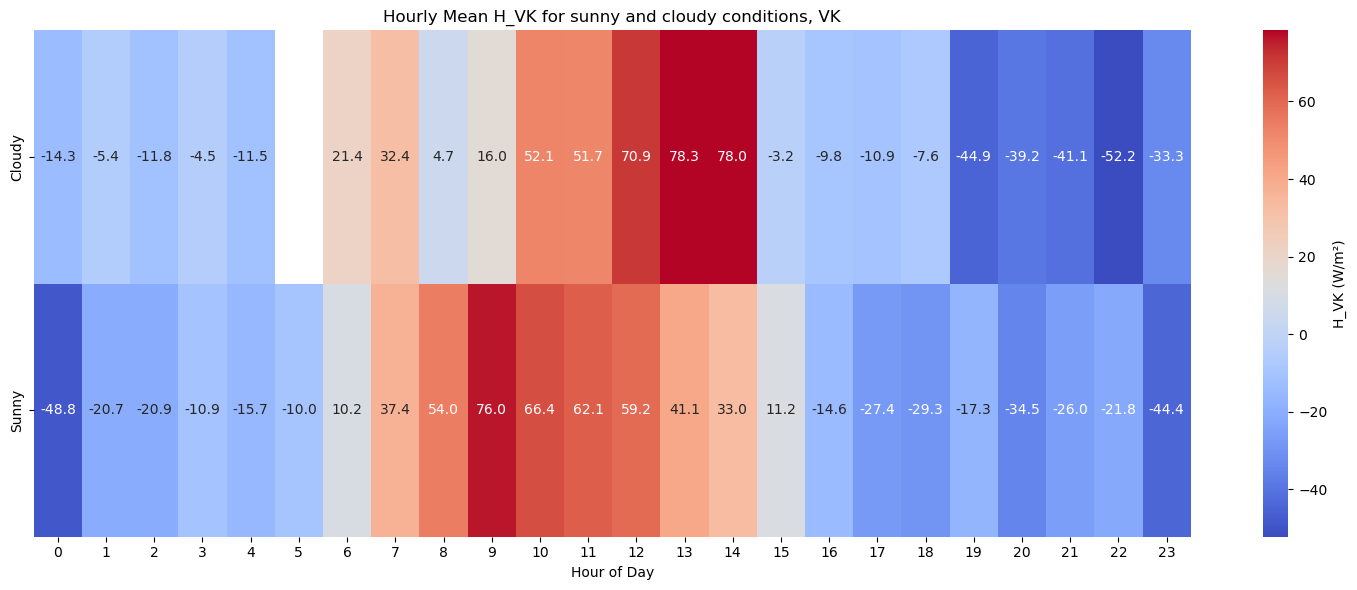

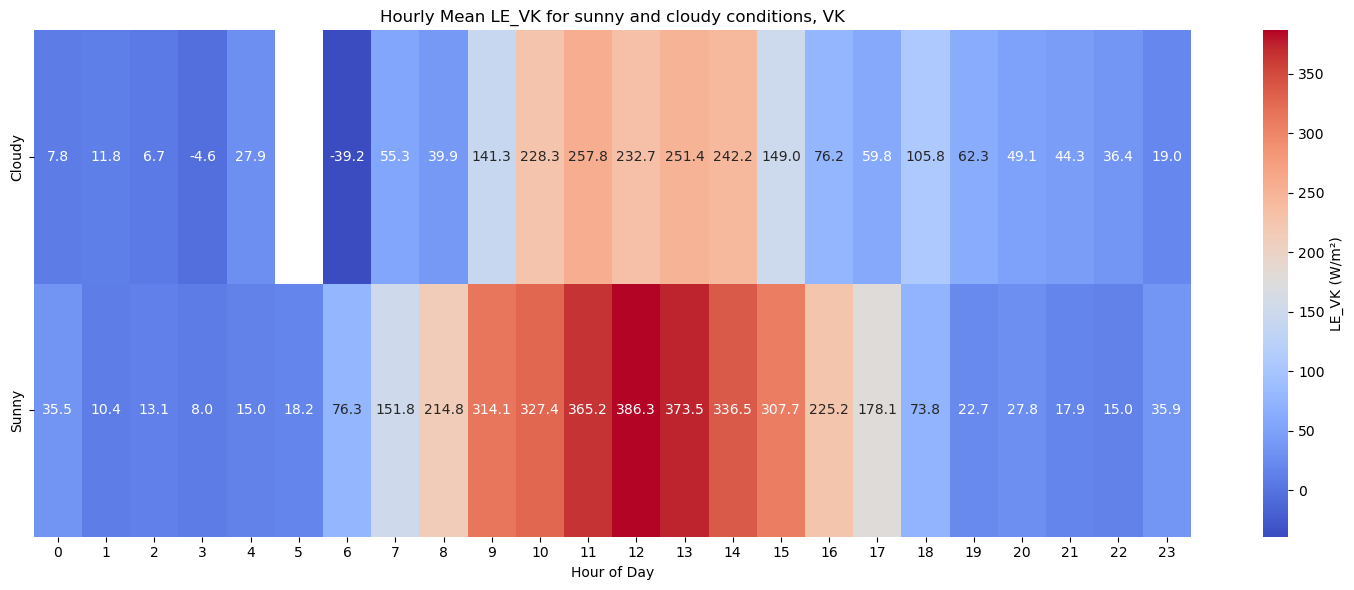

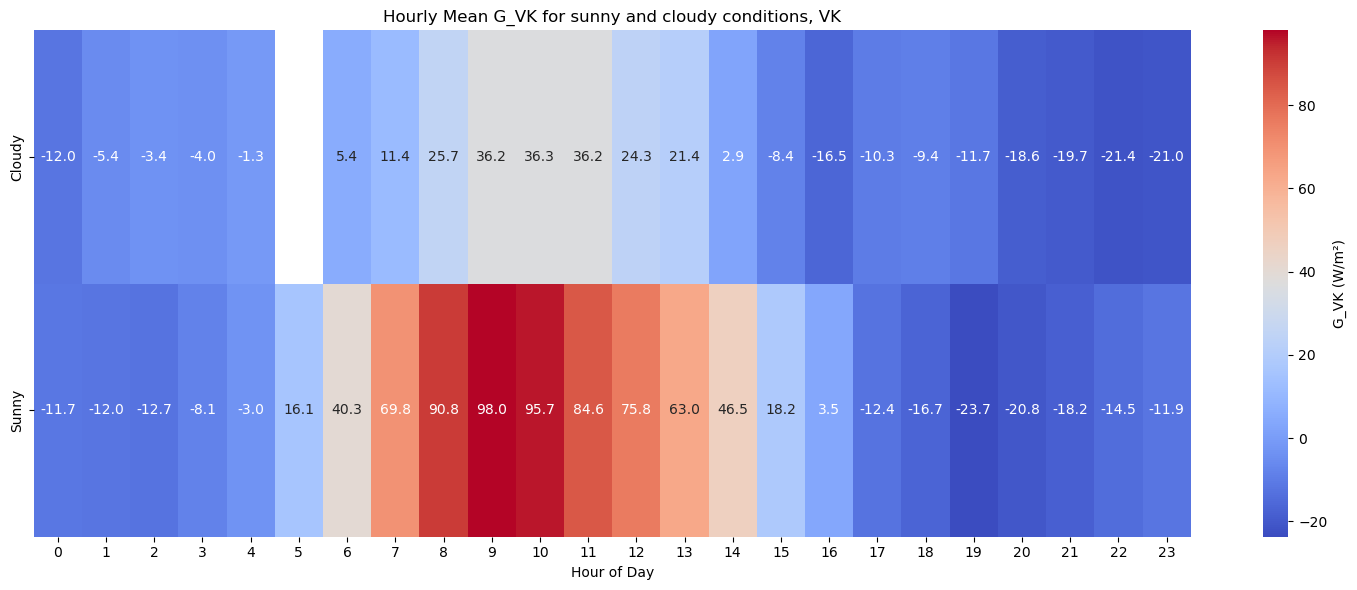

In [83]:
# What is the size of different Q* compontents in eahc hour?

# VK first
# Add 'hour' column using datetime index
sunny_VK_LB['hour'] = sunny_VK_LB.index.hour
cloudy_VK_LB['hour'] = cloudy_VK_LB.index.hour

# Variables to compare
variables = ['H_VK', 'LE_VK', 'G_VK']

# Compute hourly means
short_hourly = sunny_VK_LB.groupby('hour')[variables].mean()
tall_hourly = cloudy_VK_LB.groupby('hour')[variables].mean()

# Combine for plotting
hourly_df = pd.concat(
    {'Sunny': short_hourly, 'Cloudy': tall_hourly},
    names=['Conditions', 'Hour']
).reset_index()

# Plot heatmaps
for var in variables:
    heatmap_data = hourly_df.pivot(index='Conditions', columns='Hour', values=var)
    
    plt.figure(figsize=(15, 6))
    sns.heatmap(
        heatmap_data,
        cmap='coolwarm', annot=True, fmt=".1f",
        cbar_kws={'label': f'{var} (W/m²)'}
    )
    plt.title(f'Hourly Mean {var} for sunny and cloudy conditions, VK')
    plt.xlabel('Hour of Day')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

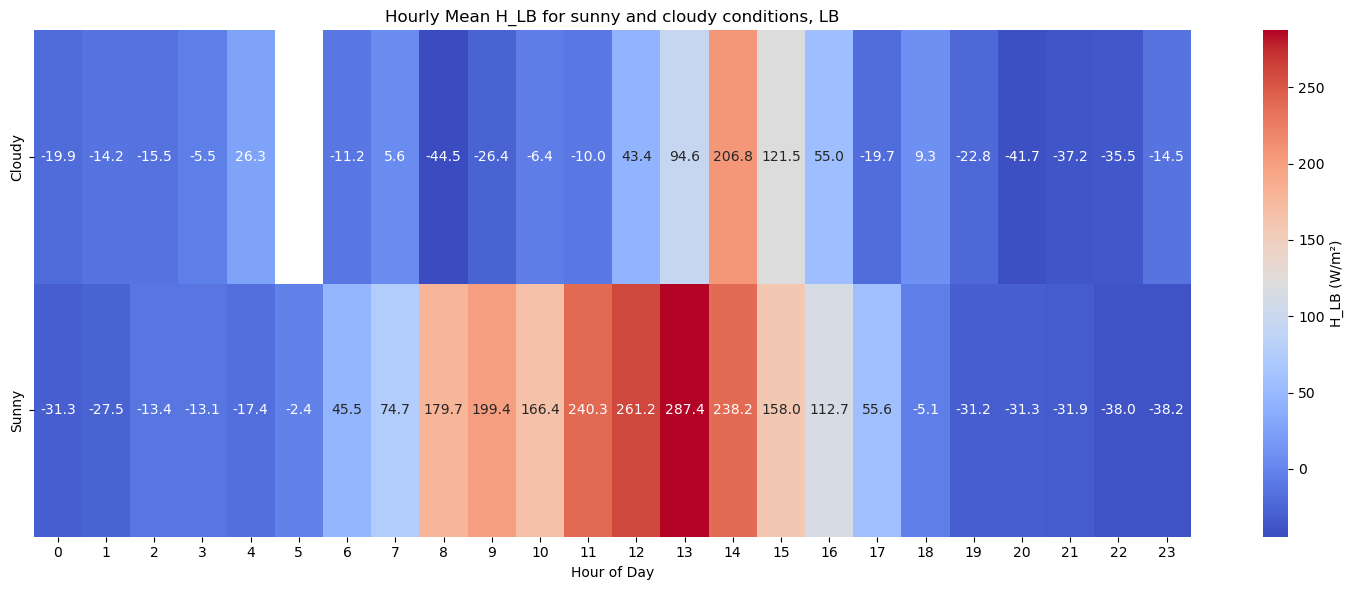

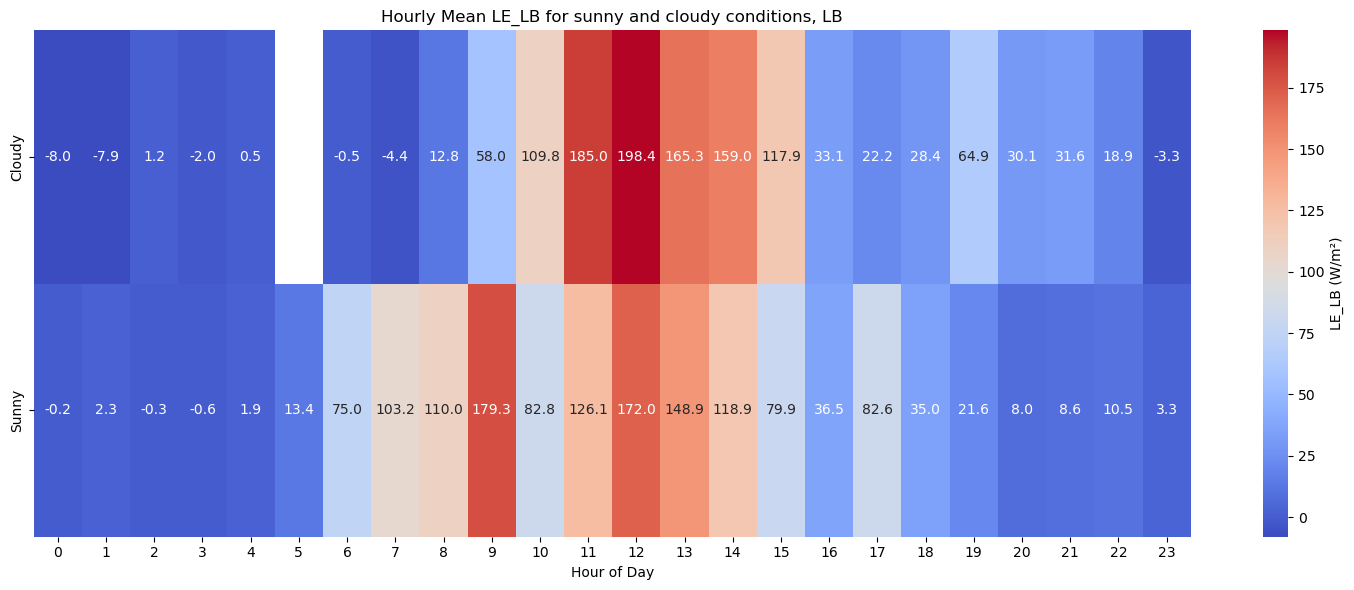

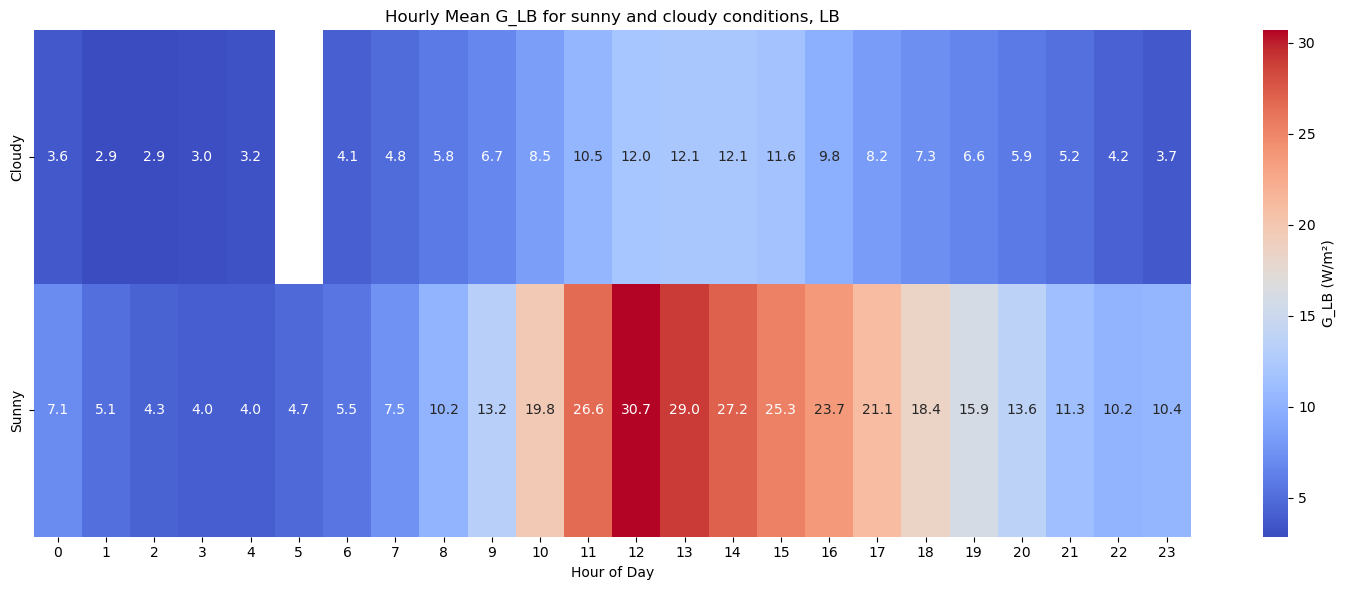

In [84]:
# Now LB
# Add 'hour' column using datetime index
sunny_VK_LB['hour'] = sunny_VK_LB.index.hour
cloudy_VK_LB['hour'] = cloudy_VK_LB.index.hour

# Variables to compare
variables = ['H_LB', 'LE_LB', 'G_LB']

# Compute hourly means
short_hourly = sunny_VK_LB.groupby('hour')[variables].mean()
tall_hourly = cloudy_VK_LB.groupby('hour')[variables].mean()

# Combine for plotting
hourly_df = pd.concat(
    {'Sunny': short_hourly, 'Cloudy': tall_hourly},
    names=['Conditions', 'Hour']
).reset_index()

# Plot heatmaps
for var in variables:
    heatmap_data = hourly_df.pivot(index='Conditions', columns='Hour', values=var)
    
    plt.figure(figsize=(15, 6))
    sns.heatmap(
        heatmap_data,
        cmap='coolwarm', annot=True, fmt=".1f",
        cbar_kws={'label': f'{var} (W/m²)'}
    )
    plt.title(f'Hourly Mean {var} for sunny and cloudy conditions, LB')
    plt.xlabel('Hour of Day')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

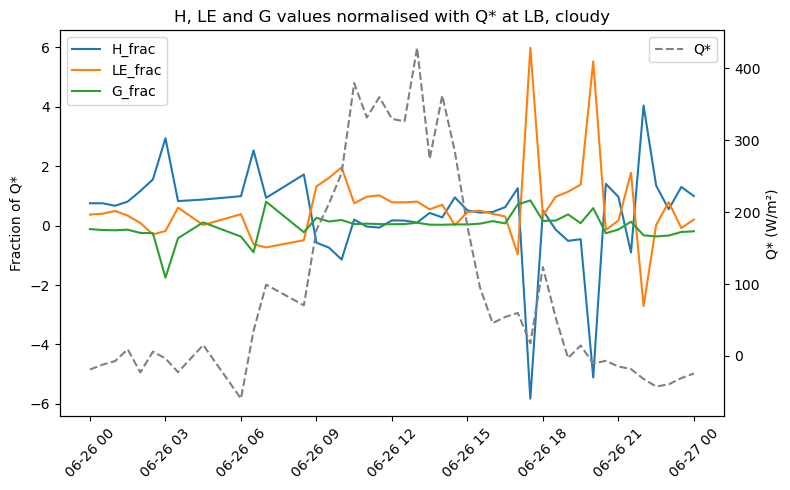

In [85]:
df = cloudy_VK_LB  # choosing conditions
loc = 'LB'
conditions='cloudy'

# Normalized fluxes
H_frac = df[f'H_{loc}'] / df[f'Q*_{loc}']
LE_frac = df[f'LE_{loc}'] / df[f'Q*_{loc}']
G_frac = df[f'G_{loc}'] / df[f'Q*_{loc}']

# Create the main plot
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot the normalized components
ax1.plot(H_frac.index, H_frac, label="H_frac")
ax1.plot(LE_frac.index, LE_frac, label="LE_frac")
ax1.plot(G_frac.index, G_frac, label="G_frac")

ax1.set_ylabel('Fraction of Q*')
ax1.legend(loc="upper left")
ax1.tick_params(axis='x', rotation=45)
ax1.set_title(f'H, LE and G values normalised with Q* at {loc}, {conditions}')

# Create secondary y-axis for Q*
ax2 = ax1.twinx()
ax2.plot(df.index, df['Q*_VK'], color='grey', linestyle='--', label='Q*')
ax2.set_ylabel('Q* (W/m²)')
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


In [86]:
# Does the Bowen ratio match the vegetation type, and does it change over time?

B_sunny_VK = sunny_VK_LB['B_VK'].mean()

B_sunny_LB = sunny_VK_LB['B_LB'].mean()

B_cloudy_VK = cloudy_VK_LB['B_VK'].mean()

B_cloudy_LB = cloudy_VK_LB['B_LB'].mean()


In [88]:
print(f'B_sunny_VK {B_sunny_VK}')
print(f'B_sunny_LB {B_sunny_LB }')
print(f'B_cloudy_VK {B_cloudy_VK}')
print(f'B_cloudy_LB {B_cloudy_LB}')


B_sunny_VK -0.5685414527331637
B_sunny_LB -2.8109995431241237
B_cloudy_VK 6.536510154900435
B_cloudy_LB 3.6722327244968067


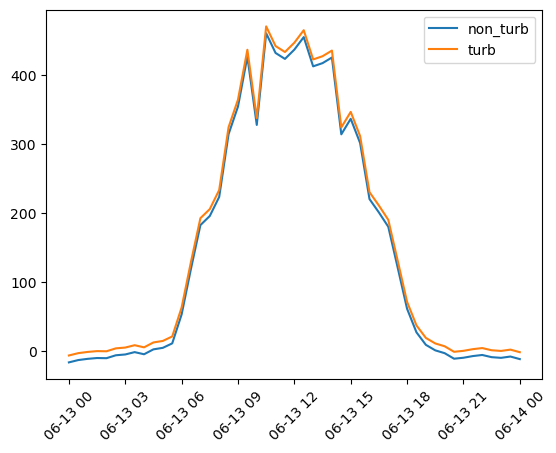

In [91]:
# Turbulent vs. not turbulent transport
# Q*-G =? H + LE
# (non-turbulent) =? (turbulent)
df = sunny_VK_LB
loc = 'VK' # VK or LB
conditions = 'sunny' # sunny or cloudy

non_turb = df[f'Q*_{loc}'] - df[f'G_{loc}']
turb = df[f'H_{loc}'] + df[f'LE_{loc}']

plt.plot(non_turb.index, non_turb, label='non_turb')
plt.plot(turb.index, turb+10, label='turb')
plt.xticks(rotation=45)
plt.legend()

In [92]:
###### Explaining the different variable values in LB/VK sunny/cloudy" ######

In [ ]:
# Downloading the meteo data

In [100]:
VK_sunny_meteo = pd.read_csv(r"C:\Users\48512\Desktop\Climate Studies\Period 5 and 6\Field Training Soil-Vegetation-Atmosphere Interactions\VK_LO\VK_meteo20250613(in).csv", sep=',', encoding="latin1", skiprows=[1])
VK_cloudy_meteo = pd.read_csv(r"C:\Users\48512\Desktop\Climate Studies\Period 5 and 6\Field Training Soil-Vegetation-Atmosphere Interactions\VK_LO\VK_meteo20250626.csv", sep=',', encoding="latin1", skiprows=[1])
LB_sunny_meteo = pd.read_csv(r"C:\Users\48512\Desktop\Climate Studies\Period 5 and 6\Field Training Soil-Vegetation-Atmosphere Interactions\VK_LO\LB_BM20250613(in).csv", sep=',', encoding="latin1", skiprows=[1])
LB_cloudy_meteo = pd.read_csv(r"C:\Users\48512\Desktop\Climate Studies\Period 5 and 6\Field Training Soil-Vegetation-Atmosphere Interactions\VK_LO\LB_BM20250626(in).csv", sep=',', encoding="latin1", skiprows=[1])

# Adding the flux data
VK_sunny_meteo_flux = pd.read_csv(r"C:\Users\48512\Desktop\Climate Studies\Period 5 and 6\Field Training Soil-Vegetation-Atmosphere Interactions\VK_LO\VK_flux20250613.csv", sep=',', encoding= "latin1" , skiprows=[1])

LB_sunny_meteo_flux = pd.read_csv(r"C:\Users\48512\Desktop\Climate Studies\Period 5 and 6\Field Training Soil-Vegetation-Atmosphere Interactions\VK_LO\LB_EC20250613.csv", sep=',', encoding= "latin1" , skiprows=[1])



In [102]:
# Show all rows
# pd.set_option('display.max_rows', None)

# # Show all columns
# pd.set_option('display.max_columns', None)

In [104]:
# Add a dateime index to all of them
# First, convert the TIMESTAMP column to datetime if it's not already
VK_sunny_meteo['datetime'] = pd.to_datetime(VK_sunny_meteo['TIMESTAMP'])
# Then set it as the index
VK_sunny_meteo.set_index('datetime', inplace=True)

VK_cloudy_meteo['datetime'] = pd.to_datetime(VK_cloudy_meteo['TIMESTAMP'])
# Then set it as the index
VK_cloudy_meteo.set_index('datetime', inplace=True)

LB_sunny_meteo['datetime'] = pd.to_datetime(LB_sunny_meteo['TIMESTAMP'])
# Then set it as the index
LB_sunny_meteo.set_index('datetime', inplace=True)

LB_cloudy_meteo['datetime'] = pd.to_datetime(LB_cloudy_meteo['TIMESTAMP'])
# Then set it as the index
LB_cloudy_meteo.set_index('datetime', inplace=True)



# Fluxes
VK_sunny_meteo_flux['datetime'] = pd.to_datetime(VK_sunny_meteo_flux['TIMESTAMP'])
VK_sunny_meteo_flux.set_index('datetime', inplace=True)

LB_sunny_meteo_flux['datetime'] = pd.to_datetime(LB_sunny_meteo_flux['TIMESTAMP'])
LB_sunny_meteo_flux.set_index('datetime', inplace=True)





In [106]:
# deleting the stupid columns

# VK_sunny_meteo.drop('D_SNOW', axis=1, inplace=True)
# VK_sunny_meteo.drop('TS_1_4_1', axis=1, inplace=True)
# VK_sunny_meteo.drop('TS_2_2_1', axis=1, inplace=True)
# VK_sunny_meteo.drop('TS_2_3_1', axis=1, inplace=True)
# VK_sunny_meteo.drop('TIMESTAMP', axis=1, inplace=True)

# VK_sunny_meteo = VK_sunny_meteo.dropna()

# LB_sunny_meteo.drop('D_SNOW', axis=1, inplace=True)
# LB_sunny_meteo.drop('TS_1_4_1', axis=1, inplace=True)
# LB_sunny_meteo.drop('TS_2_2_1', axis=1, inplace=True)
# LB_sunny_meteo.drop('TS_2_3_1', axis=1, inplace=True)
LB_sunny_meteo.drop('TIMESTAMP', axis=1, inplace=True)

LB_sunny_meteo = VK_sunny_meteo.dropna()

In [108]:
# for col_name in LB_sunny_meteo.columns:
#     print(col_name, VK_sunny_meteo[col_name].dtype)

In [110]:
# Meteo data every 30min
VK_sunny_meteo_30min = VK_sunny_meteo.resample('30T', label='left', closed='left').mean()
LB_sunny_meteo_30min = VK_sunny_meteo.resample('30T', label='left', closed='left').mean()

C:\Users\48512\AppData\Local\Temp\ipykernel_24860\791700900.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  VK_sunny_meteo_30min = VK_sunny_meteo.resample('30T', label='left', closed='left').mean()


TypeError: agg function failed [how->mean,dtype->object]

In [114]:
# Merging the flux data
EB_VK_sunny_meteo_30min = pd.merge(VK_sunny_meteo_30min, VK_sunny_meteo_flux, left_index=True, right_index=True, how='inner')
EB_LB_sunny_meteo_30min = pd.merge(LB_sunny_meteo_30min, LB_sunny_meteo_flux, left_index=True, right_index=True, how='inner')

NameError: name 'VK_sunny_meteo_30min' is not defined

In [116]:
# Cleaningn NaN

VK_sunny_meteo = VK_sunny_meteo.dropna(subset=['SW_OUT_1_1_1', 'SW_IN_1_1_1'])

VK_cloudy_meteo = VK_cloudy_meteo.dropna(subset=['SW_OUT_1_1_1', 'SW_IN_1_1_1'])

LB_sunny_meteo = LB_sunny_meteo.dropna(subset=['SW_OUT_1_1_1', 'SW_IN_1_1_1'])

LB_cloudy_meteo = LB_cloudy_meteo.dropna(subset=['SW_OUT_1_1_1', 'SW_IN_1_1_1'])

In [118]:
# Adding albedo column

VK_sunny_meteo['albedo'] = VK_sunny_meteo['SW_OUT_1_1_1'] / VK_sunny_meteo['SW_IN_1_1_1']
VK_cloudy_meteo['albedo'] = VK_cloudy_meteo['SW_OUT_1_1_1'] / VK_cloudy_meteo['SW_IN_1_1_1']

LB_sunny_meteo['albedo'] = LB_sunny_meteo['SW_OUT_1_1_1'] / LB_sunny_meteo['SW_IN_1_1_1']
LB_cloudy_meteo['albedo'] = LB_cloudy_meteo['SW_OUT_1_1_1'] / LB_cloudy_meteo['SW_IN_1_1_1']

In [120]:
# Albedo, only during the day

# Define daytime hours, e.g., 6 AM to 6 PM
daytime_hours = range(5, 22)  # 6 to 18 inclusive

# Filter rows where the hour of the datetime index is in daytime_hours
df = LB_sunny_meteo
daytime_data = df[df.index.hour.isin(daytime_hours)]

# # Calculate mean albedo during daytime hours
mean_albedo_day = daytime_data['albedo'].mean(skipna=True)
mean_albedo_day

nan

In [122]:
# albedo VK sun 0.2710719563844633
# albedo VK cloudy ?
# albedo cloudy LB 0.16022048873844785
# albedo sunny LB 0.154276988941252

In [124]:
LB_sunny_meteo

,TIMESTAMP,TA_2_1_1,TW_2_1_1,TA_1_1_1,TW_1_1_1,TA_1_2_1,TA_1_1_2,RH_1_1_1,SW_IN_1_1_1,SW_OUT_1_1_1,LW_IN_1_1_1,LW_OUT_1_1_1,RN_1_1_1,SW_DIF_1_1_1,SW_DIR_1_1_1,LW_IN_2_1_1,SW_DUR_1_1_1,VIS_1_1_1,P_1_1_7,D_SNOW,PA_1_1_1,WS_2_1_1,WX_2_1_1,WS_1_1_1,WX_1_1_1,WD_1_1_1,WS_1_2_1,WX_1_2_1,WD_1_2_1,WTD_1_1_1,TS_1_1_1,TS_1_2_1,TS_1_3_1,TS_1_4_1,TS_1_5_1,TS_1_6_1,TS_2_1_1,TS_2_2_1,TS_2_3_1,TS_2_4_1,G_1_1_1,G_2_1_1,G_3_1_1,G_4_1_1,VWC_1_1_1,VWC_1_2_1,VWC_1_3_1,VWC_1_4_1,VWC_2_1_1,VWC_2_2_1,VWC_2_3_1,VWC_2_4_1,VWC_3_1_1,P_1_1_2,P_1_1_3,P_1_1_1,P_1_1_4,P_1_1_5,P_1_1_6,albedo
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [126]:
pd.reset_option('display.max_rows')

In [128]:
# # H, sunny
# # (Ta-Ts)
# # Temperature Vaisala (1.5 m) for Ta
# # Dry bulb temperature shielded (10 cm) for Ts
# # Not sure if this is the right surface temperature but will have to be for now
# VK_sunny_meteo['TaTs'] = VK_sunny_meteo['TA_1_1_1'] - VK_sunny_meteo['TA_1_2_1']

# LB_sunny_meteo['TaTs'] = LB_sunny_meteo['TA_2_5_1'] - LB_sunny_meteo['TA_1_1_2']

In [130]:
EB_LB_sunny_meteo_30min

NameError: name 'EB_LB_sunny_meteo_30min' is not defined

In [132]:
# Ratio of H to air temperature, is it similar in both places in a sunny day?

EB_VK_sunny_meteo_30min['TaH'] = EB_VK_sunny_meteo_30min['TA_1_1_1'] / EB_VK_sunny_meteo_30min['H']

EB_LB_sunny_meteo_30min['TaH'] = EB_LB_sunny_meteo_30min['TA_1_1_1'] / EB_LB_sunny_meteo_30min['H']
#EB_LB_sunny_meteo_30min['TaH'] = EB_LB_sunny_meteo_30min['TaH'].drop('2025-06-13 06:00:00', axis=0, inplace=True)
EB_LB_sunny_meteo_30min.drop('2025-06-13 06:00:00', inplace=True)

NameError: name 'EB_VK_sunny_meteo_30min' is not defined

In [134]:
EB_LB_sunny_meteo_30min

NameError: name 'EB_LB_sunny_meteo_30min' is not defined

In [136]:
EB_VK_sunny_meteo_30min['TaH'].mean()

NameError: name 'EB_VK_sunny_meteo_30min' is not defined

In [138]:
EB_LB_sunny_meteo_30min['TaH'].mean()

NameError: name 'EB_LB_sunny_meteo_30min' is not defined

In [ ]:
t_stat, p_value = ttest_ind(EB_VK_sunny_meteo_30min['TaH'], EB_LB_sunny_meteo_30min['TaH'], equal_var=True)

print("T-statistic:", t_stat)
print("P-value:", p_value)

In [ ]:
ratio_check = EB_VK_sunny_meteo_30min['TaH'] - EB_LB_sunny_meteo_30min['TaH']
ratio_check

In [ ]:
plt.plot(EB_VK_sunny_meteo_30min.index, EB_VK_sunny_meteo_30min['TaH'], label='VK')
plt.plot(EB_LB_sunny_meteo_30min.index, EB_LB_sunny_meteo_30min['TaH'], label='LB')
plt.xlabel('time')
plt.ylabel('Ta/H ratio [-]')
plt.title('Ratio of Ta and H on a sunny day in Vk and LB')
plt.legend()
plt.xticks(rotation=45)

In [ ]:
EB_LB_sunny_meteo_30min['Ts']

In [150]:
EB_

NameError: name 'EB_VK_sunny_meteo_30min' is not defined